# Лабораторная работа №2. Стохастический градиентный спуск.

In [1]:
import cvxpy as cp
import numpy as np
from sklearn.datasets import make_spd_matrix

import time
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
n = np.arange(10, 41, 10)
N = 10
P = 10
ε = 0.1

DIM = 10

In [4]:
def function(x: np.array, A: np.array, mu: np.array) -> float:
    return ((x-mu).T @ A @ (x-mu))[0]

In [5]:
def optimal(x: np.array, A: np.array, mu: np.array) -> bool:
    grad_const = 2 * x
    grad_func = 2 * A @ (x - mu)
    return grad_const.T @ -grad_func > 0

In [6]:
def euclid_distance(x: np.array, y: np.array) -> float:
    return ((y - x)**2).sum()**(1/2)

# 1) Двойственная задача

Целевая функция имеет вид: $(x−mu)^⊤A(x−mu) \to min$.

Ограничение: $∥x∥^2_2 = ∥x∥^2 = x^Tx ≤1$.

Функция Лагранжа $L(x, λ)$ имеет вид:

$L(x, λ) = (x−mu)^⊤A(x−mu) + λ(x^T x - 1)$.

Производная функции Лагранжа:

$\frac{dL(x, λ)}{dx} = 2A(x−mu) + 2λx = 0$, сократим её в два раза (ничего не потеряем, так как всё равно приравниваем к нулю) $\frac{dL(x, λ)}{dx} = A(x−mu) + λx = 0$.

Выражаем значение $x^*$:

$A(x^*−mu) + λx^* = 0$

$Ax^* − Amu + λx^* = 0$

$Ax^* + λx^* = Amu$

$(A + λE)x^* = Amu$

$x^* = (A + λE)^{-1}Amu$

Подставляем полученное значение $x^*$ в $L(x, λ)$:

$g(λ) = ((A + λE)^{-1}Amu-mu)^T A ((A + λE)^{-1}Amu-mu) + λ(((A + λE)^{-1}Amu)^T (A + λE)^{-1}Amu - 1)$

Таким образом ***двойственная задача*** выглядит следующим образом:

Целевая функция: $g(λ) = ((A + λE)^{-1}Amu-mu)^T A ((A + λE)^{-1}Amu-mu) + λ(((A + λE)^{-1}Amu)^T (A + λE)^{-1}Amu - 1) \to max$

Ограничение: $λ ≥ 0$

Тогда производная двойственной функции $g(λ)$ по $λ$ имеет следующий вид:

$∇g(λ) = \frac{dg(λ)}{dλ} = -2((A+λE)^{-1}Amu - mu)^T A ((A+λE)^{-2}Amu) + (((A+λE)^{-1}Amu)^T (A+λE)^{-1}Amu - 1) - 2λ((A+λE)^{-1}Amu)^T (A+λE)^{-2}Amu$

Упростим двойственную целевую функцию и её производную с помощью замены $t_1 = (A+λE)^{-1}$ и $t_2 = A*mu$, тогда производная будет выглядеть:

$g(λ) = (t_1 t_2 - mu)^T A (t_1 t_2 - mu) + λ((t_1 t_2)^T t_1 t_2 - 1) \to max$

$∇g(λ) = -2(t_1 t_2 - mu)^T A (t_1^2 t_2) + ((t_1 t_2)^T t_1 t_2 - 1) -2λ(t_1 t_2)^T t_1^2 t_2$

In [7]:
def double_function(lambde: np.array, A: np.array, mu: np.array) -> float:
    n = A.shape[0]
    t_1 = np.linalg.inv(A + lambde * np.eye(n))
    t_2 = A @ mu
    return ((t_1 @ t_2 - mu).T @ A @ (t_1 @ t_2 - mu) + lambde * ((t_1 @ t_2).T @ t_1 @ t_2 - 1))[0]

In [8]:
def gradient_double_function(lambde: np.array, A: np.array, mu: np.array) -> np.array:
    n = A.shape[0]
    t_1 = np.linalg.inv(A + lambde * np.eye(n))
    t_2 = A @ mu
    return -2 * (t_1 @ t_2 - mu).T @ A @ (t_1 @ t_1 @ t_2) + ((t_1 @ t_2).T @ t_1 @ t_2 - 1) -2 * lambde * (t_1 @ t_2).T @ t_1 @ t_1 @ t_2

### CVX

In [ ]:
data = {}

for dim in tqdm(n):
    data[dim] = {i: {} for i in range(N)}
    for i in range(N):
        A = make_spd_matrix(n_dim=dim)
        x = cp.Variable(shape=(dim, 1))
        mu = np.ones(shape=(dim, 1))
        objective = cp.Minimize(cp.quad_form(x-mu, A))
        constraints = [cp.sum_squares(x) <= 1]
        problem = cp.Problem(objective, constraints)
        res = problem.solve(solver=cp.SCS)

        optimal(x.value, A, mu)

        data[dim][i]["A"] = A
        data[dim][i]["X opt solver"] = x.value
        data[dim][i]["Result solver"] = res

100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


### Gradient descent for strongly convex and smooth functions в изначальной задаче.

In [9]:
def gradient_descent_first(x: np.array, A: np.array, res_solver: float, ε: float) -> list:
    iterations = 0

    eigenvalues = np.linalg.eigvals(A)
    alpha = 2 * eigenvalues.min()
    beta = 2 * eigenvalues.max()
    step = 2 / (alpha + beta)

    dim = x.shape[0]
    mu = np.ones(shape=(dim, 1))
    constraint_center = np.zeros(shape=(dim, 1))

    res_grad_primal = function(x, A, mu)
    while abs(res_solver - res_grad_primal) > ε:
        x = x - step * 2 * A @ (x - mu)
        if euclid_distance(constraint_center, x) > 1:
            x = x / euclid_distance(constraint_center, x)

        res_grad_primal = function(x, A, mu)

        iterations += 1

    return iterations

In [ ]:
average_time_grad_first = []
average_iterations_grad_first = []
for dim in tqdm(n):
    iterations = 0
    time_start = time.time()

    for i in range(N):
        A = data[dim][i]["A"]
        res_solver = data[dim][i]["Result solver"]

        for p in range(P):
            x = np.random.randint(low=0, high=100, size=(dim, 1))
            x = x/np.linalg.norm(x, ord=2)

            iterations += gradient_descent_first(x, A, res_solver, ε)
    average_time_grad_first.append((time.time() - time_start) / (N * P))
    average_iterations_grad_first.append(iterations / (N * P))

100%|██████████| 4/4 [00:00<00:00, 16.28it/s]


### Gradient descent for strongly convex and smooth functions в двойственной задаче.

In [10]:
def gradient_descent_double(lambde: np.array, A: np.array, res_solver: float, ε: float) -> list:
    iterations = 0

    eigenvalues = np.linalg.eigvals(A)
    alpha = 2 * eigenvalues.min()
    beta = 2 * eigenvalues.max()
    step = 2 / (alpha + beta)

    dim = A.shape[1]
    mu = np.ones(shape=(dim, 1))

    res_grad_dual = double_function(lambde, A, mu)
    while abs(res_solver - res_grad_dual) > ε:
        lambde = lambde + step * gradient_double_function(lambde, A, mu)
        if lambde <= 0:
            lambde = 0

        res_grad_dual = double_function(lambde, A, mu)
        iterations += 1

    return iterations

In [ ]:
average_time_grad_double = []
average_iterations_grad_double = []
for dim in tqdm(n):
    iterations = 0
    time_start = time.time()

    for i in range(N):
        A = data[dim][i]["A"]
        res_solver = data[dim][i]["Result solver"]

        for p in range(P):
            lambde = np.random.rand(1, 1)

            iterations += gradient_descent_double(lambde, A, res_solver, ε)
    average_time_grad_double.append((time.time() - time_start) / (N * P))
    average_iterations_grad_double.append(iterations / (N * P))

100%|██████████| 4/4 [00:19<00:00,  4.99s/it]


### 2) Стохастический градиентный спуск для Gradient descent for strongly convex and smooth functions в изначальной задаче.

Стохастический градиент: $\widetilde{∇}f(x)=\frac{1}{m}\sum_{j=1}^{m}(0, 0, ..., 0, nf'_{x_i}, 0, ..., 0)^T$, где $i$ выбирается случайным образом от 1 до $n$ на каждой итерации $j$, $m$ — варьируемый параметр.

Основным отличием стохастического градиентного спуска от его обычной версии является то, что шаг оптимизации происходит по произвольной компоненте, а не по всем сразу.

In [11]:
def stochastic_gradient_descent_first(x: np.array, A: np.array, res_solver: float, ε: float, m: float) -> list:
    iterations = 0

    eigenvalues = np.linalg.eigvals(A)
    alpha = 2 * eigenvalues.min()
    beta = 2 * eigenvalues.max()
    step = 2 / (alpha + beta)

    dim = x.shape[0]
    mu = np.ones(shape=(dim, 1))
    constraint_center = np.zeros(shape=(dim, 1))

    res_stoh_grad_primal = function(x, A, mu)
    while abs(res_solver - res_stoh_grad_primal) > ε:
        grad = np.zeros(shape=(dim, 1))
        for j in range(m):
            i = np.random.randint(low=0, high=dim, size=(1))
            grad[i] += dim * 2 * A[i] @ (x - mu)
        grad = grad / m

        x = x - step * grad
        if euclid_distance(constraint_center, x) > 1:
            x = x / euclid_distance(constraint_center, x)

        res_stoh_grad_primal = function(x, A, mu)

        step = max(step * 0.999, 0.0001)
        iterations += 1

    return iterations

In [29]:
average_time_stoh_grad_first = {}
average_iterations_stoh_grad_first = {}
for dim in tqdm(n):
    average_time_stoh_grad_first[dim] = []
    average_iterations_stoh_grad_first[dim] = []
    for m in set([1, int(dim/8), int(dim/4), int(dim/2), dim]):
        iterations = 0
        time_start = time.time()

        for i in range(N):
            A = data[dim][i]["A"]
            res_solver = data[dim][i]["Result solver"]

            for p in range(P):
                x = np.random.randint(low=0, high=100, size=(dim, 1))
                x = x/np.linalg.norm(x, ord=2)

                iterations += stochastic_gradient_descent_first(x, A, res_solver, ε, m)
        average_time_stoh_grad_first[dim].append((time.time() - time_start) / (N * P))
        average_iterations_stoh_grad_first[dim].append(iterations / (N * P))

100%|██████████| 4/4 [16:36<00:00, 249.16s/it]


### Стохастический градиентный спуск для Gradient descent for strongly convex and smooth functions в двойственной задаче.

Для двойственной задачи, из-за наличия всего одной переменной, стохастический градиентный спуск сводится к обычному ($n \to 1$, $m \to 1$).

In [12]:
def stochastic_gradient_descent_double(lambde: np.array, A: np.array, res_solver: float, ε: float, m: float) -> list:
    iterations = 0

    eigenvalues = np.linalg.eigvals(A)
    alpha = 2 * eigenvalues.min()
    beta = 2 * eigenvalues.max()
    step = 2 / (alpha + beta)

    dim = lambde.shape[0]
    mu = np.ones(shape=(A.shape[0], 1))

    res_stoh_grad_dual = double_function(lambde, A, mu)
    while abs(res_solver - res_stoh_grad_dual) > ε:
        grad = np.zeros(shape=(dim, 1))
        grad_full = gradient_double_function(lambde, A, mu)
        for j in range(m):
            i = np.random.randint(low=0, high=dim, size=(1))
            grad[i] += dim * grad_full
        grad = grad / m

        lambde = lambde + step * grad
        if lambde <= 0:
            lambde = 0

        res_stoh_grad_dual = double_function(lambde, A, mu)

        step = max(step * 0.999, 0.0001)
        iterations += 1

    return iterations

In [ ]:
average_time_stoh_grad_double = {}
average_iterations_stoh_grad_double = {}
for dim in tqdm(n):
    average_time_stoh_grad_double[dim] = []
    average_iterations_stoh_grad_double[dim] = []
    for m in sorted(set([1, int(dim/8), int(dim/4), int(dim/2), dim])):
        iterations = 0
        time_start = time.time()

        for i in range(N):
            A = data[dim][i]["A"]
            res_solver = data[dim][i]["Result solver"]

            for p in tqdm(range(P)):
                lambde = np.random.rand(1, 1)

                iterations += stochastic_gradient_descent_double(lambde, A, res_solver, ε, m)
        average_time_stoh_grad_double[dim].append((time.time() - time_start) / (N * P))
        average_iterations_stoh_grad_double[dim].append(iterations / (N * P))

# 3) Сравнение результатов

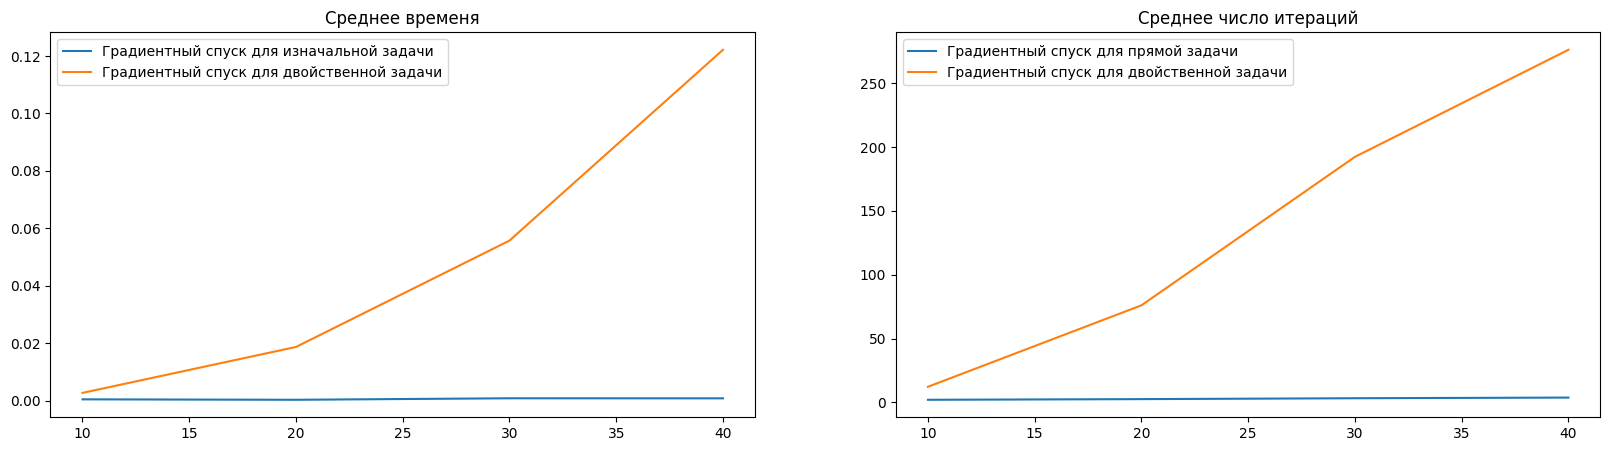

In [102]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))

axes[0].plot(n, average_time_grad_first, label=f"Градиентный спуск для изначальной задачи")
axes[0].plot(n, average_time_grad_double, label=f"Градиентный спуск для двойственной задачи")
axes[0].set_title("Среднее временя")
axes[0].legend()

axes[1].plot(n, average_iterations_grad_first, label=f"Градиентный спуск для прямой задачи")
axes[1].plot(n, average_iterations_grad_double, label=f"Градиентный спуск для двойственной задачи")
axes[1].set_title("Среднее число итераций")
axes[1].legend()

plt.show()

In [114]:
n

array([10, 20, 30, 40])

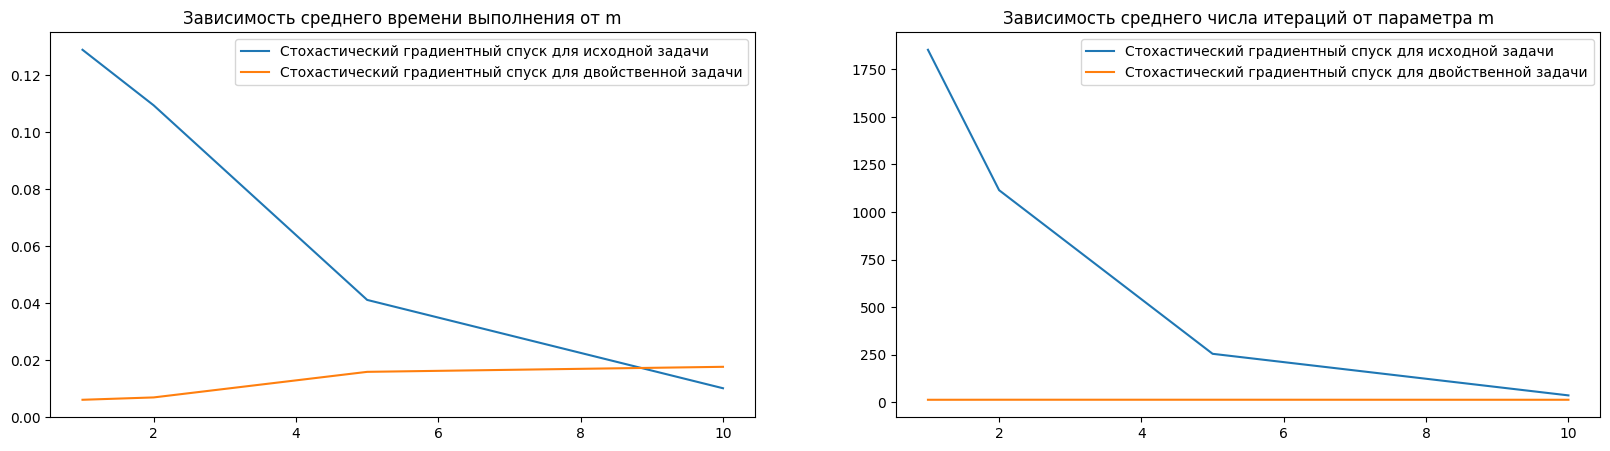

In [115]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
dim = n[0]
m = sorted(set([1, int(dim/8), int(dim/4), int(dim/2), dim]))
axes[0].plot(m, average_time_stoh_grad_first[dim], label=f"Стохастический градиентный спуск для исходной задачи")
axes[0].plot(m, average_time_stoh_grad_double[dim], label=f"Стохастический градиентный спуск для двойственной задачи")
axes[0].set_title("Зависимость среднего времени выполнения от m")
axes[0].legend()
axes[1].plot(m, average_iterations_stoh_grad_first[dim], label=f"Стохастический градиентный спуск для исходной задачи")
axes[1].plot(m, average_iterations_stoh_grad_double[dim], label=f"Стохастический градиентный спуск для двойственной задачи")
axes[1].set_title("Зависимость среднего числа итераций от параметра m")
axes[1].legend()

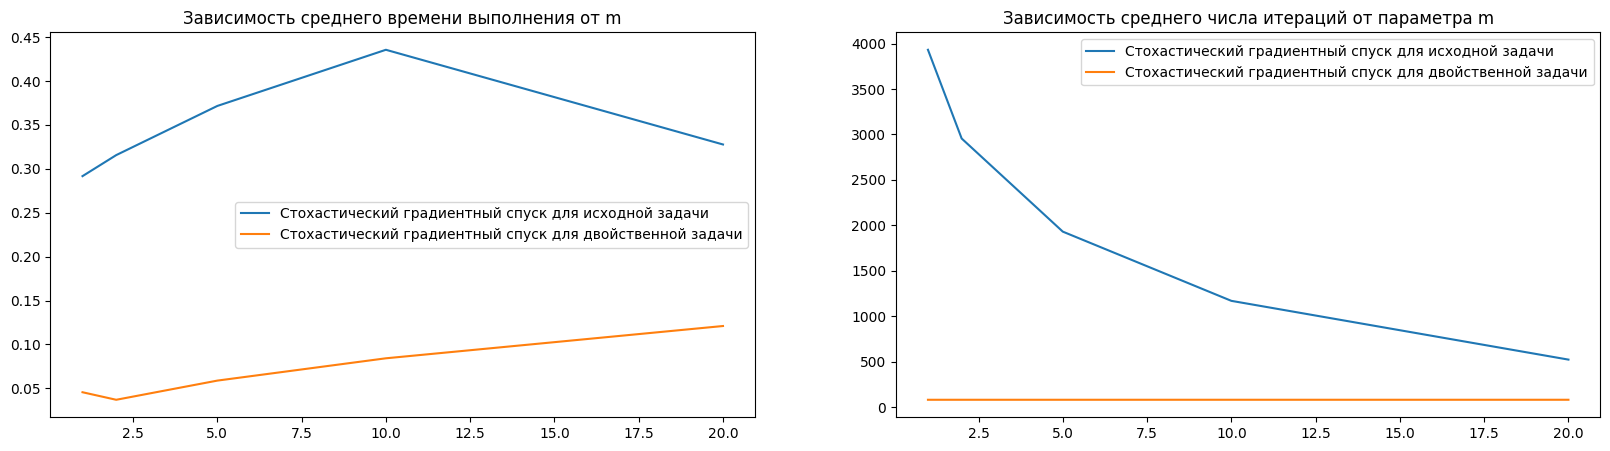

In [116]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
dim = n[1]
m = sorted(set([1, int(dim/8), int(dim/4), int(dim/2), dim]))
axes[0].plot(m, average_time_stoh_grad_first[dim], label=f"Стохастический градиентный спуск для исходной задачи")
axes[0].plot(m, average_time_stoh_grad_double[dim], label=f"Стохастический градиентный спуск для двойственной задачи")
axes[0].set_title("Зависимость среднего времени выполнения от m")
axes[0].legend()
axes[1].plot(m, average_iterations_stoh_grad_first[dim], label=f"Стохастический градиентный спуск для исходной задачи")
axes[1].plot(m, average_iterations_stoh_grad_double[dim], label=f"Стохастический градиентный спуск для двойственной задачи")
axes[1].set_title("Зависимость среднего числа итераций от параметра m")
axes[1].legend()

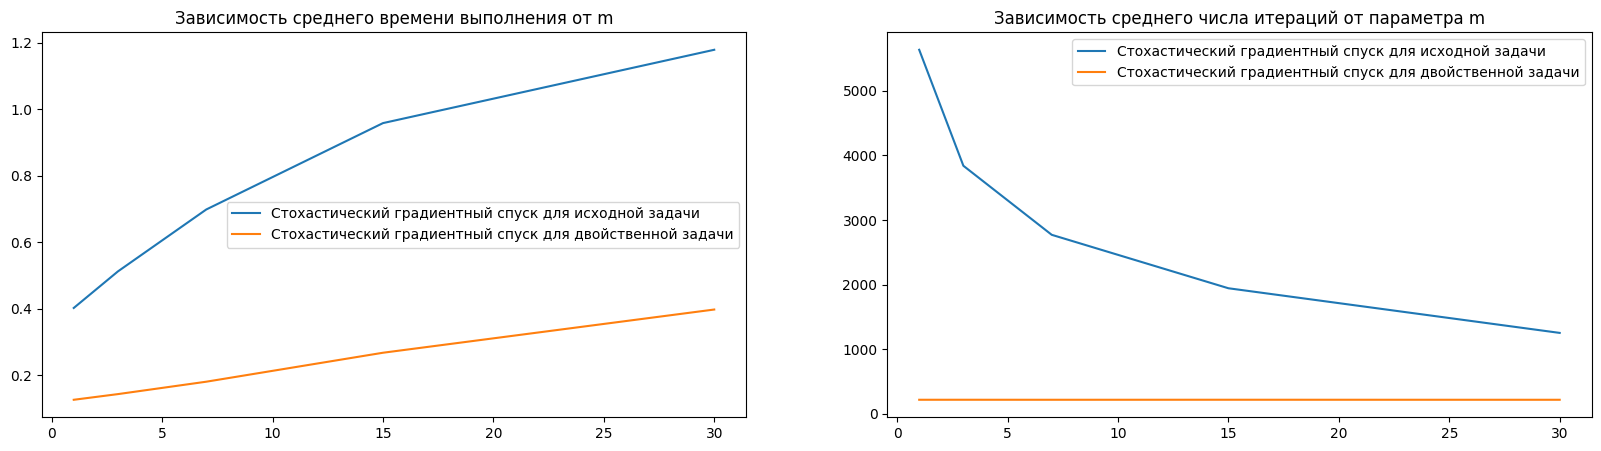

In [117]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
dim = n[2]
m = sorted(set([1, int(dim/8), int(dim/4), int(dim/2), dim]))
axes[0].plot(m, average_time_stoh_grad_first[dim], label=f"Стохастический градиентный спуск для исходной задачи")
axes[0].plot(m, average_time_stoh_grad_double[dim], label=f"Стохастический градиентный спуск для двойственной задачи")
axes[0].set_title("Зависимость среднего времени выполнения от m")
axes[0].legend()
axes[1].plot(m, average_time_stoh_grad_first[dim], label=f"Стохастический градиентный спуск для исходной задачи")
axes[1].plot(m, average_iterations_stoh_grad_double[dim], label=f"Стохастический градиентный спуск для двойственной задачи")
axes[1].set_title("Зависимость среднего числа итераций от параметра m")
axes[1].legend()

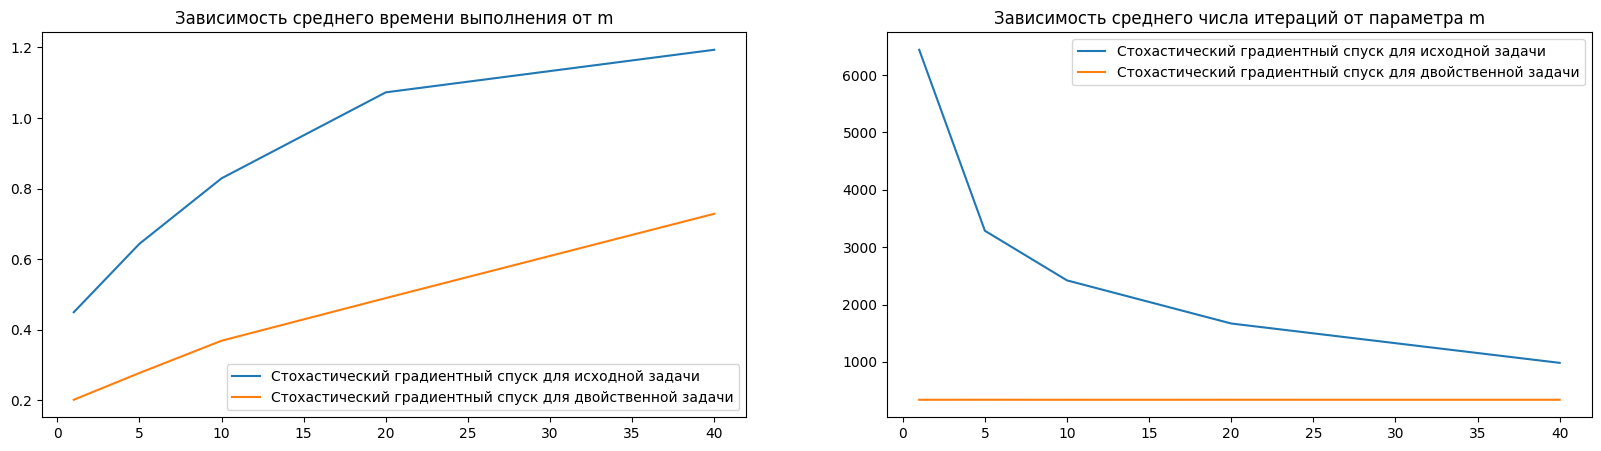

In [119]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
dim = n[3]
m = sorted(set([1, int(dim/8), int(dim/4), int(dim/2), dim]))
axes[0].plot(m, average_time_stoh_grad_first[dim], label=f"Стохастический градиентный спуск для исходной задачи")
axes[0].plot(m, average_time_stoh_grad_double[dim], label=f"Стохастический градиентный спуск для двойственной задачи")
axes[0].set_title("Зависимость среднего времени выполнения от m")
axes[0].legend()
axes[1].plot(m, average_time_stoh_grad_first[dim], label=f"Стохастический градиентный спуск для исходной задачи")
axes[1].plot(m, average_iterations_stoh_grad_double[dim], label=f"Стохастический градиентный спуск для двойственной задачи")
axes[1].set_title("Зависимость среднего числа итераций от параметра m")
axes[1].legend()

In [13]:
accuracy = {}

A = data[DIM][0]["A"]
mu = np.ones(shape=(DIM, 1))
constraint_center = np.zeros(shape=(DIM, 1))
res_solver = data[DIM][0]["Result solver"]

eigenvalues = np.linalg.eigvals(A)
alpha = 2 * eigenvalues.min()
beta = 2 * eigenvalues.max()
step = 2 / (alpha + beta)

start_points = []

for p in range(6):
    x = np.random.randint(low=0, high=100, size=(DIM, 1))
    x = x/np.linalg.norm(x, ord=2)
    start_points.append(x)

NameError: name 'data' is not defined

In [122]:
accuracy["grad"] = {}

for p in range(6):
    accuracy["grad"][p] = []

    x = start_points[p]
    res_grad_primal = function(x, A, mu)

    accuracy["grad"][p].append(abs(res_solver - res_grad_primal))

    while abs(res_solver - res_grad_primal) > ε:
        x = x - step * 2 * A @ (x - mu)
        if euclid_distance(constraint_center, x) > 1:
            x = x / euclid_distance(constraint_center, x)
        res_grad_primal = function(x, A, mu)

        accuracy["grad"][p].append(abs(res_solver - res_grad_primal))

In [123]:
for m in sorted(set([1, int(DIM/8), int(DIM/4), int(DIM/2), DIM])):
    accuracy[f"stoh grad m={m}"] = {}

    for p in range(6):
        accuracy[f"stoh grad m={m}"][p] = []

        x = start_points[p]
        res_stoh_grad_primal = function(x, A, mu)

        accuracy[f"stoh grad m={m}"][p].append(abs(res_solver - res_stoh_grad_primal))

        while abs(res_solver - res_stoh_grad_primal) > ε:
            grad = np.zeros(shape=(DIM, 1))
            for j in range(m):
                i = np.random.randint(low=0, high=DIM, size=(1))
                grad[i] += DIM * 2 * A[i] @ (x - mu)
            grad = grad / m
            x = x - step * grad
            if euclid_distance(constraint_center, x) > 1:
                x = x / euclid_distance(constraint_center, x)

            res_stoh_grad_primal = function(x, A, mu)

            step = max(step * 0.999, 0.0001)
            accuracy[f"stoh grad m={m}"][p].append(abs(res_solver - res_stoh_grad_primal))

In [124]:
m = sorted(set([1, int(DIM/8), int(DIM/4), int(DIM/2), DIM]))
m

[1, 2, 5, 10]

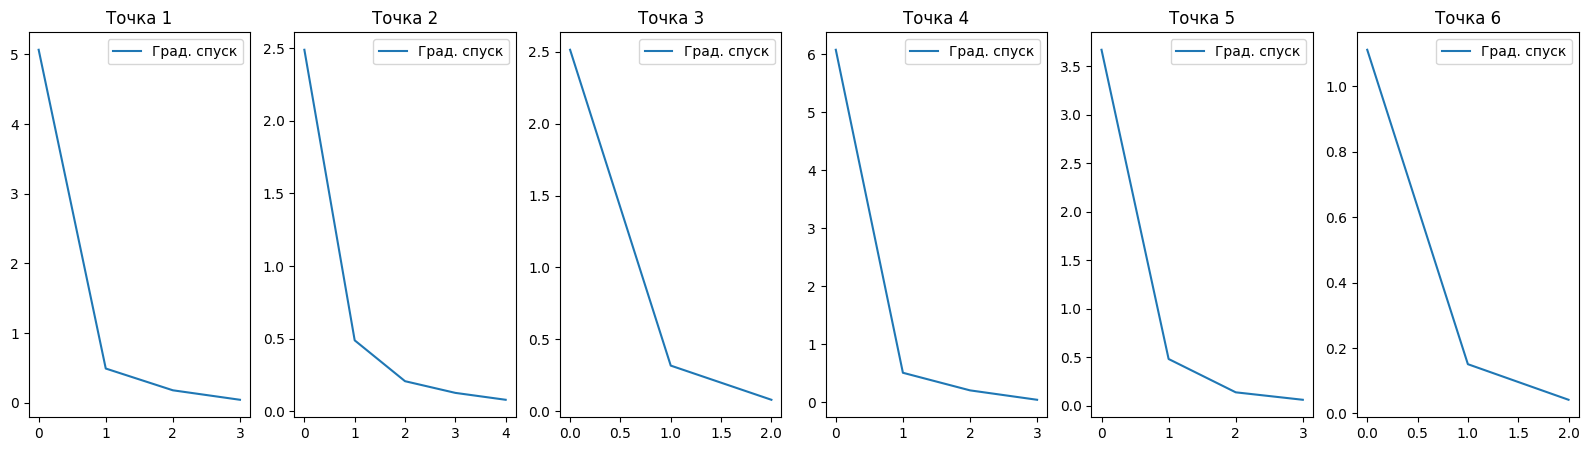

In [130]:
fig, axes = plt.subplots(ncols=6, figsize=(20,5))
for col in range(6):
  axes[col].plot(range(len(accuracy["grad"][col])), accuracy["grad"][col], label="Град. спуск")
  axes[col].set_title(f"Точка {col+1}")
  axes[col].legend()

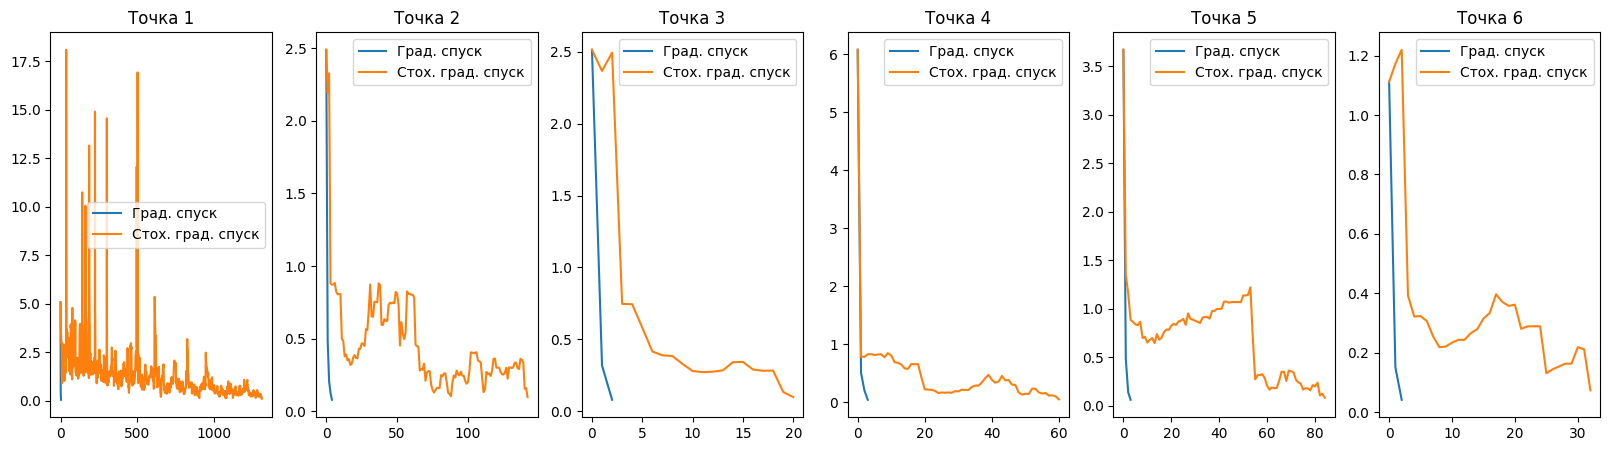

In [131]:
fig, axes = plt.subplots(ncols=6, figsize=(20,5))
for col in range(6):
  axes[col].plot(range(len(accuracy["grad"][col])), accuracy["grad"][col], label="Град. спуск")
  axes[col].plot(range(len(accuracy[f"stoh grad m={m[0]}"][col])), accuracy[f"stoh grad m={m[0]}"][col], label="Стох. град. спуск")
  axes[col].set_title(f"Точка {col+1}")
  axes[col].legend()

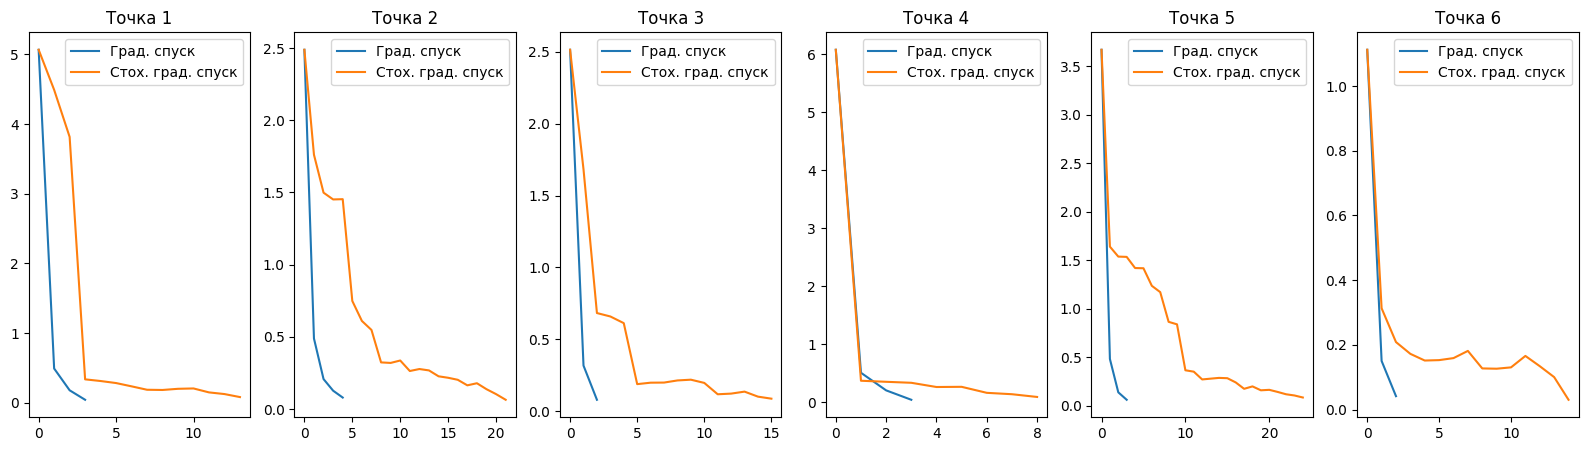

In [134]:
fig, axes = plt.subplots(ncols=6, figsize=(20,5))
for col in range(6):
  axes[col].plot(range(len(accuracy["grad"][col])), accuracy["grad"][col], label="Град. спуск")
  axes[col].plot(range(len(accuracy[f"stoh grad m={m[1]}"][col])), accuracy[f"stoh grad m={m[1]}"][col], label="Стох. град. спуск")
  axes[col].set_title(f"Точка {col+1}")
  axes[col].legend()

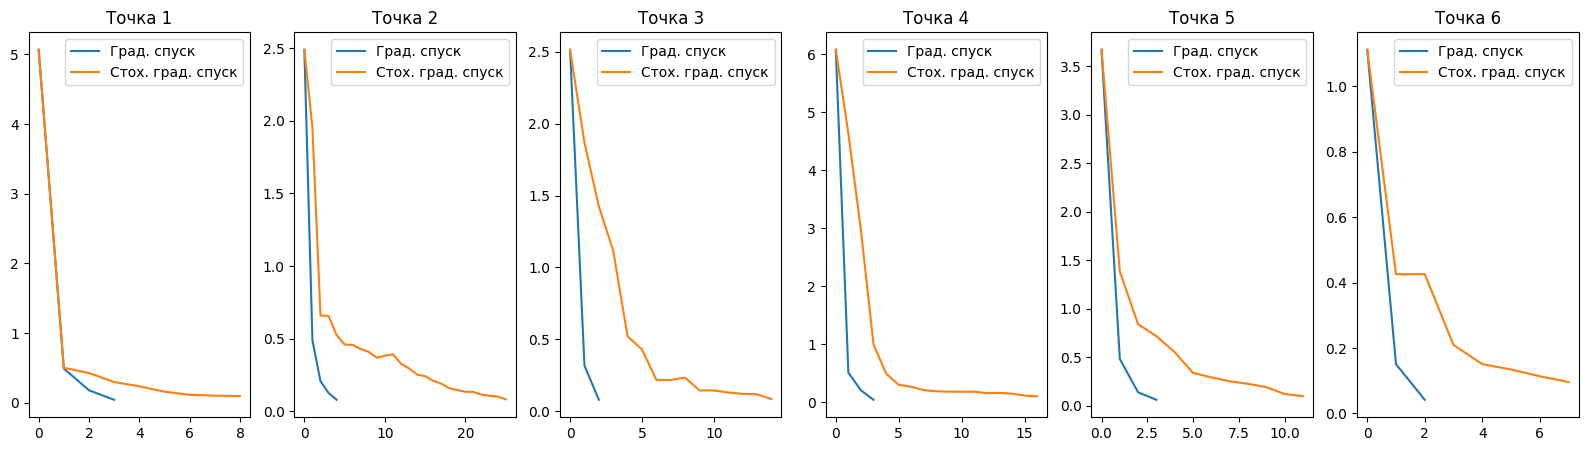

In [132]:
fig, axes = plt.subplots(ncols=6, figsize=(20,5))
for col in range(6):
  axes[col].plot(range(len(accuracy["grad"][col])), accuracy["grad"][col], label="Град. спуск")
  axes[col].plot(range(len(accuracy[f"stoh grad m={m[2]}"][col])), accuracy[f"stoh grad m={m[2]}"][col], label="Стох. град. спуск")
  axes[col].set_title(f"Точка {col+1}")
  axes[col].legend()

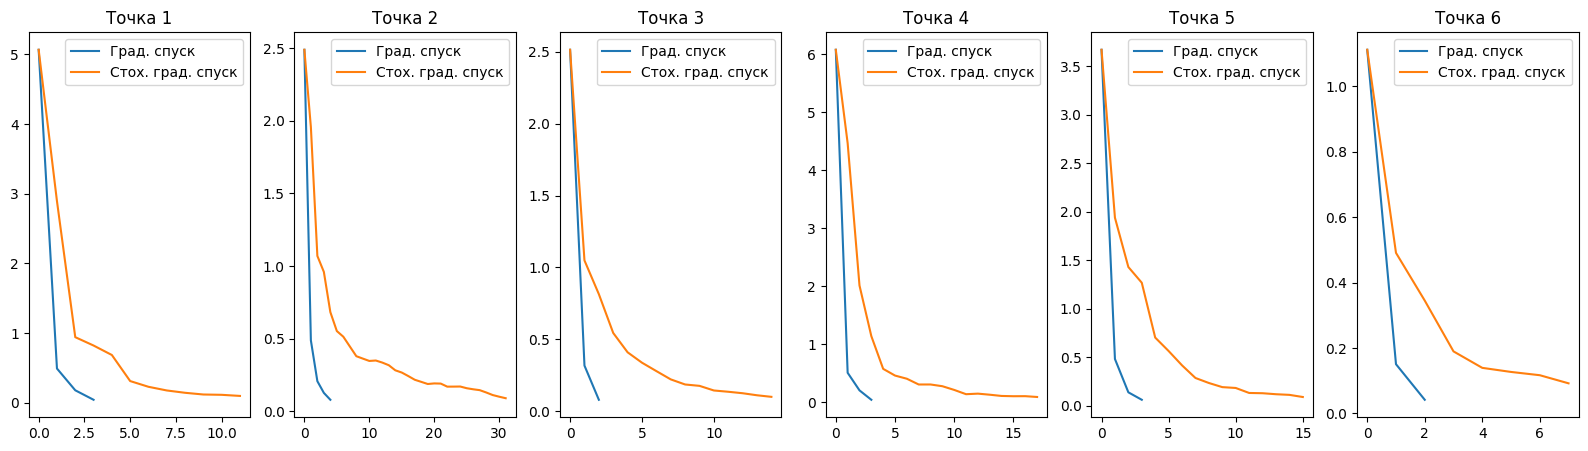

In [133]:
fig, axes = plt.subplots(ncols=6, figsize=(20,5))
for col in range(6):
  axes[col].plot(range(len(accuracy["grad"][col])), accuracy["grad"][col], label="Град. спуск")
  axes[col].plot(range(len(accuracy[f"stoh grad m={m[3]}"][col])), accuracy[f"stoh grad m={m[3]}"][col], label="Стох. град. спуск")
  axes[col].set_title(f"Точка {col+1}")
  axes[col].legend()